In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [37]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,accuracy_score,roc_curve



In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

In [4]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, ResNet152,VGG19
from tensorflow.keras.optimizers import Adam
import time


In [5]:
base_path = '/kaggle/input/food-101/food-101/food-101/'
meta_path = os.path.join(base_path, 'meta')
images_path = os.path.join(base_path, 'images')

In [6]:
image_dir = Path('/kaggle/input/food-101/food-101/food-101/')

In [ ]:
filepaths = list(image_dir.glob(r'**/*.jpg'))



In [ ]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)


In [ ]:
category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice)
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [ ]:
image_df

In [ ]:
image_df['Label'].value_counts()

In [ ]:
import random
from PIL import Image

# Number of images to display
num_images = 9


random_indx = random.sample(range(len(train_df)), num_images)
random_images = train_df.iloc[random_indx]


fig, axes = plt.subplots(3, 3, figsize=(5, 5))
axes = axes.flatten()

for ax, (filepath, label) in zip(axes, zip(random_images['Filepath'], random_images['Label'])):
 
    img = Image.open(filepath)
    ax.imshow(img)
    ax.axis('off')  
    ax.set_title(label, fontsize=10)  

plt.tight_layout()
plt.show()


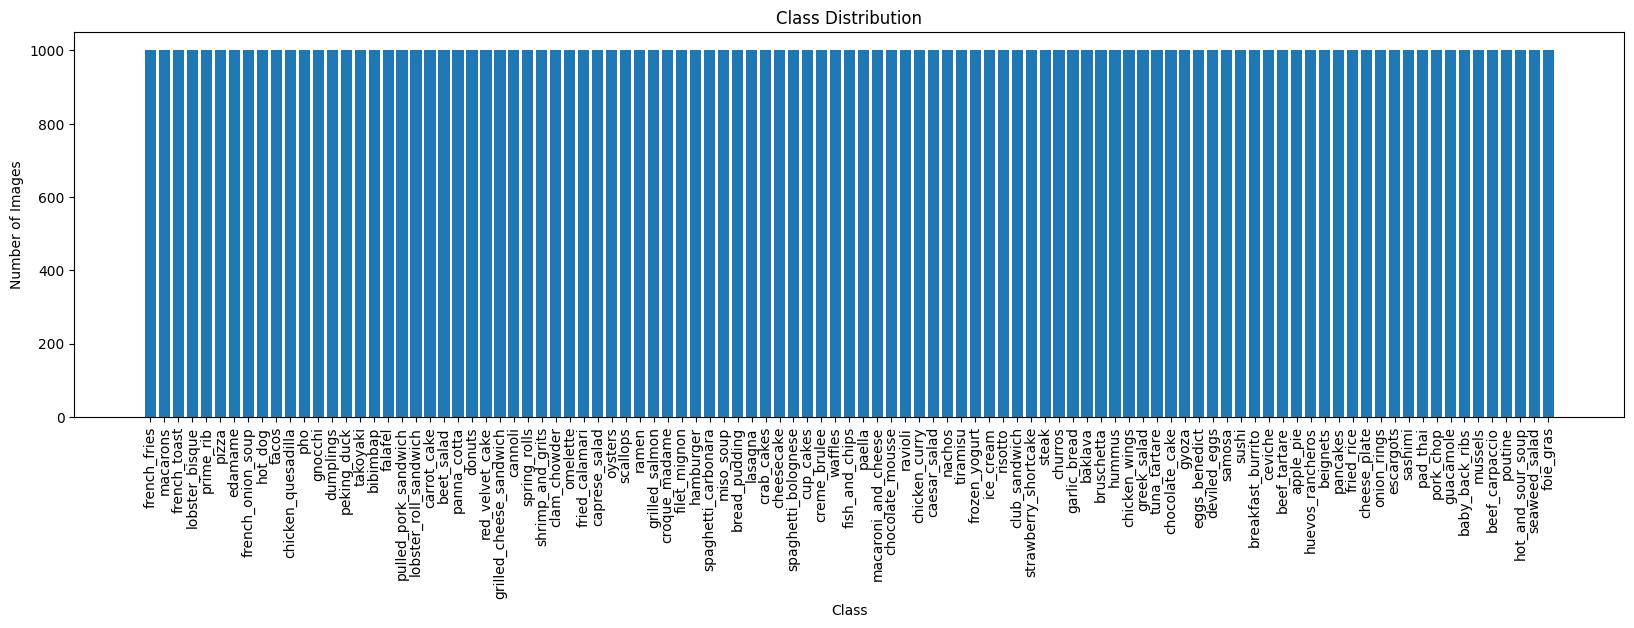

In [18]:
plt.figure(figsize = (20,5))
class_counts = images['Label'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


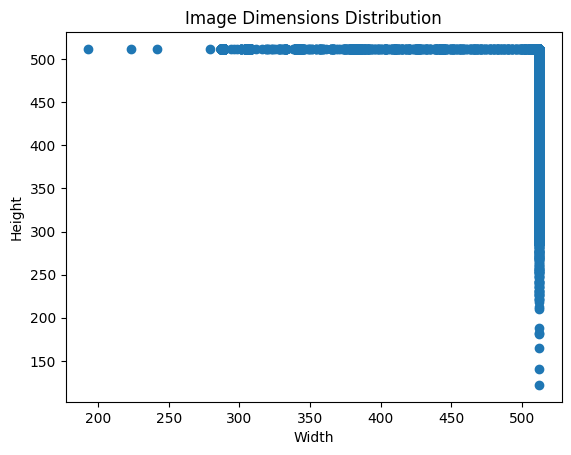

In [34]:
import numpy as np
from PIL import Image

image_sizes = []
for img_path in filepaths:  # Replace `image_paths` with your actual list of image file paths
    img = Image.open(img_path)
    image_sizes.append(img.size)

image_sizes = np.array(image_sizes)
plt.scatter(image_sizes[:, 0], image_sizes[:, 1])
plt.title("Image Dimensions Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()


# Preprocessing For Classifiers

In [24]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [25]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [28]:
input_shape = (224,224)
batch_size = 1024

In [29]:

train_images = train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=input_shape,
color_mode='rgb',
class_mode='categorical',
batch_size=batch_size,
shuffle=True,
seed=42,
subset='training'
)
val_images = train_generator.flow_from_dataframe(
dataframe=train_df,
x_col='Filepath',
y_col='Label',
target_size=input_shape,
color_mode='rgb',
class_mode='categorical',
batch_size=batch_size,
shuffle=True,
seed=42,
subset='validation'
)
test_images = test_generator.flow_from_dataframe(
dataframe=test_df,
x_col='Filepath',
y_col='Label',
target_size=input_shape,
color_mode='rgb',
class_mode='categorical',
batch_size=batch_size,
shuffle=False
)

Found 56560 validated image filenames belonging to 101 classes.
Found 14140 validated image filenames belonging to 101 classes.
Found 30300 validated image filenames belonging to 101 classes.


# Model Training

In [41]:
def print_header(title):
    print("\n" + "="*50)
    print(f"{title.center(50)}")
    print("="*50 + "\n")

def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

def model_evaluation(model, test_images, ):
    # Print Header for Evaluation    
    print_header('MODEL EVALUATION')

    # Predict on Test Images
    test_preds = model.predict(test_images)
    test_labels = test_images.labels  

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds.argmax(axis=1)))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(test_labels, test_preds.argmax(axis=1))
    plt.figure(figsize=(20, 20))
    sns.heatmap(
        cm,
        fmt='d',
        cmap='Blues',
        xticklabels=test_images.class_indices.keys(),
        yticklabels=test_images.class_indices.keys()
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    


In [32]:

# Custom Callback for Loss Improvement Logging
class LossImprovementCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch == 0:
            self.prev_loss = logs.get('val_loss')
        else:
            improvement = self.prev_loss - logs.get('val_loss')
            print(f"Epoch {epoch + 1}: Validation Loss Improvement: {improvement:.4f}")
            self.prev_loss = logs.get('val_loss')

def pretrained_model_fit(pretrained_model,model_name,train_images,val_images, test_images,epochs= 20,monitor = 'val_loss',monitor_mode = 'auto'):
    inputs = pretrained_model.input
    x = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = tf.keras.layers.Dense(101, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    print_header('SUMMARY OF THE MODEL')
    print(model.summary())
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    # Model Training
    print_header('MODEL TRAINING')
    checkpoint_filepath = f'best_{model_name}.keras'
    checkpoint = ModelCheckpoint(
        checkpoint_filepath,
        save_best_only=True,
        monitor=monitor,
        mode=monitor_mode,
        verbose=1
    )
    history = model.fit(
        train_images,
        validation_data=val_images,
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor=monitor,
                patience=5,
                restore_best_weights=True
            ),
            checkpoint,
            LossImprovementCallback()
        ]
    )
    print_header('TRAINING HISTORY PLOTS')
    plot_history(history)    
    best_model = load_model(checkpoint_filepath)
    return best_model



## MobileNetV2


In [33]:
mobile_net_v2 = tf.keras.applications.MobileNetV2(
input_shape=(224, 224, 3),
include_top=False,
weights='imagenet',
pooling='avg'
)
mobile_net_v2.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step



               SUMMARY OF THE MODEL               



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,722,853 (18.02 MB)

 Trainable params: 2,464,869 (9.40 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None

                  MODEL TRAINING                  

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.8216 - accuracy: 0.2317 - loss: 3.3944

2024-12-10 16:46:43.087549: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[828,32,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[828,32,112,112]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-10 16:46:43.534269: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.446829296s
Trying algorithm eng3{k11=2} for conv (f32[828,32,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[828,32,112,112]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=32, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id


Epoch 1: val_loss improved from inf to 1.88239, saving model to best_mobile_net_v2.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 390s 6s/step - AUC: 0.8231 - accuracy: 0.2338 - loss: 3.3823 - val_AUC: 0.9557 - val_accuracy: 0.5189 - val_loss: 1.8824
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.9549 - accuracy: 0.5124 - loss: 1.8818
Epoch 2: val_loss improved from 1.88239 to 1.70860, saving model to best_mobile_net_v2.keras
Epoch 2: Validation Loss Improvement: 0.1738
56/56 ━━━━━━━━━━━━━━━━━━━━ 289s 5s/step - AUC: 0.9549 - accuracy: 0.5126 - loss: 1.8810 - val_AUC: 0.9599 - val_accuracy: 0.5630 - val_loss: 1.7086
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.9658 - accuracy: 0.5797 - loss: 1.5977
Epoch 3: val_loss improved from 1.70860 to 1.63528, saving model to best_mobile_net_v2.keras
Epoch 3: Validation Loss Improvement: 0.0733
56/56 ━━━━━━━━━━━━━━━━━━━━ 286s 5s/step - AUC: 0.9658 - accuracy: 0.5797 - loss: 1.5977 - val_AUC: 0.9626 - val_accuracy: 0.5775 - val_loss: 1.6

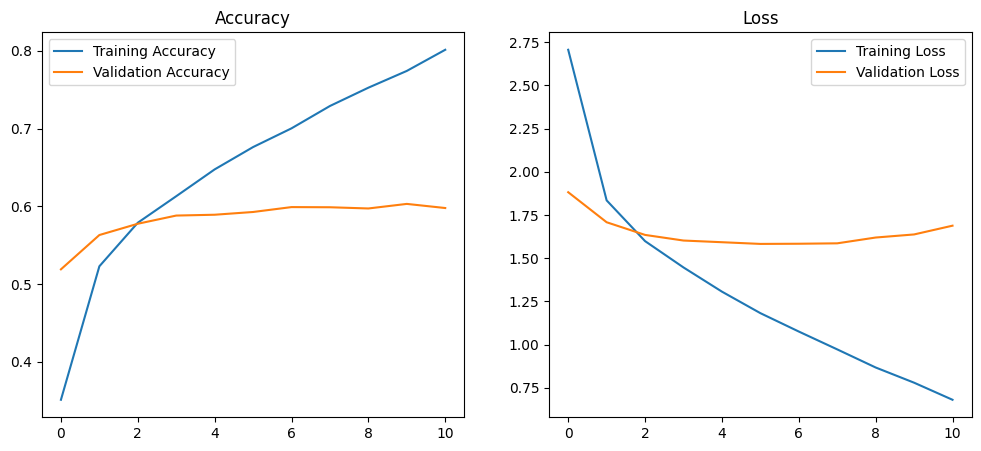

In [35]:
mobile_net_model = pretrained_model_fit(mobile_net_v2,'mobile_net_v2',train_images,val_images,test_images)


                 MODEL EVALUATION                 

30/30 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.24      0.30       297
           1       0.65      0.56      0.60       285
           2       0.65      0.55      0.60       293
           3       0.60      0.67      0.63       273
           4       0.52      0.54      0.53       293
           5       0.45      0.44      0.44       291
           6       0.69      0.79      0.73       281
           7       0.75      0.76      0.75       303
           8       0.38      0.25      0.30       307
           9       0.60      0.50      0.55       323
          10       0.39      0.49      0.43       268
          11       0.72      0.62      0.67       303
          12       0.58      0.66      0.62       324
          13       0.48      0.52      0.50       298
          14       0.88      0.39      0.55       319
          15      

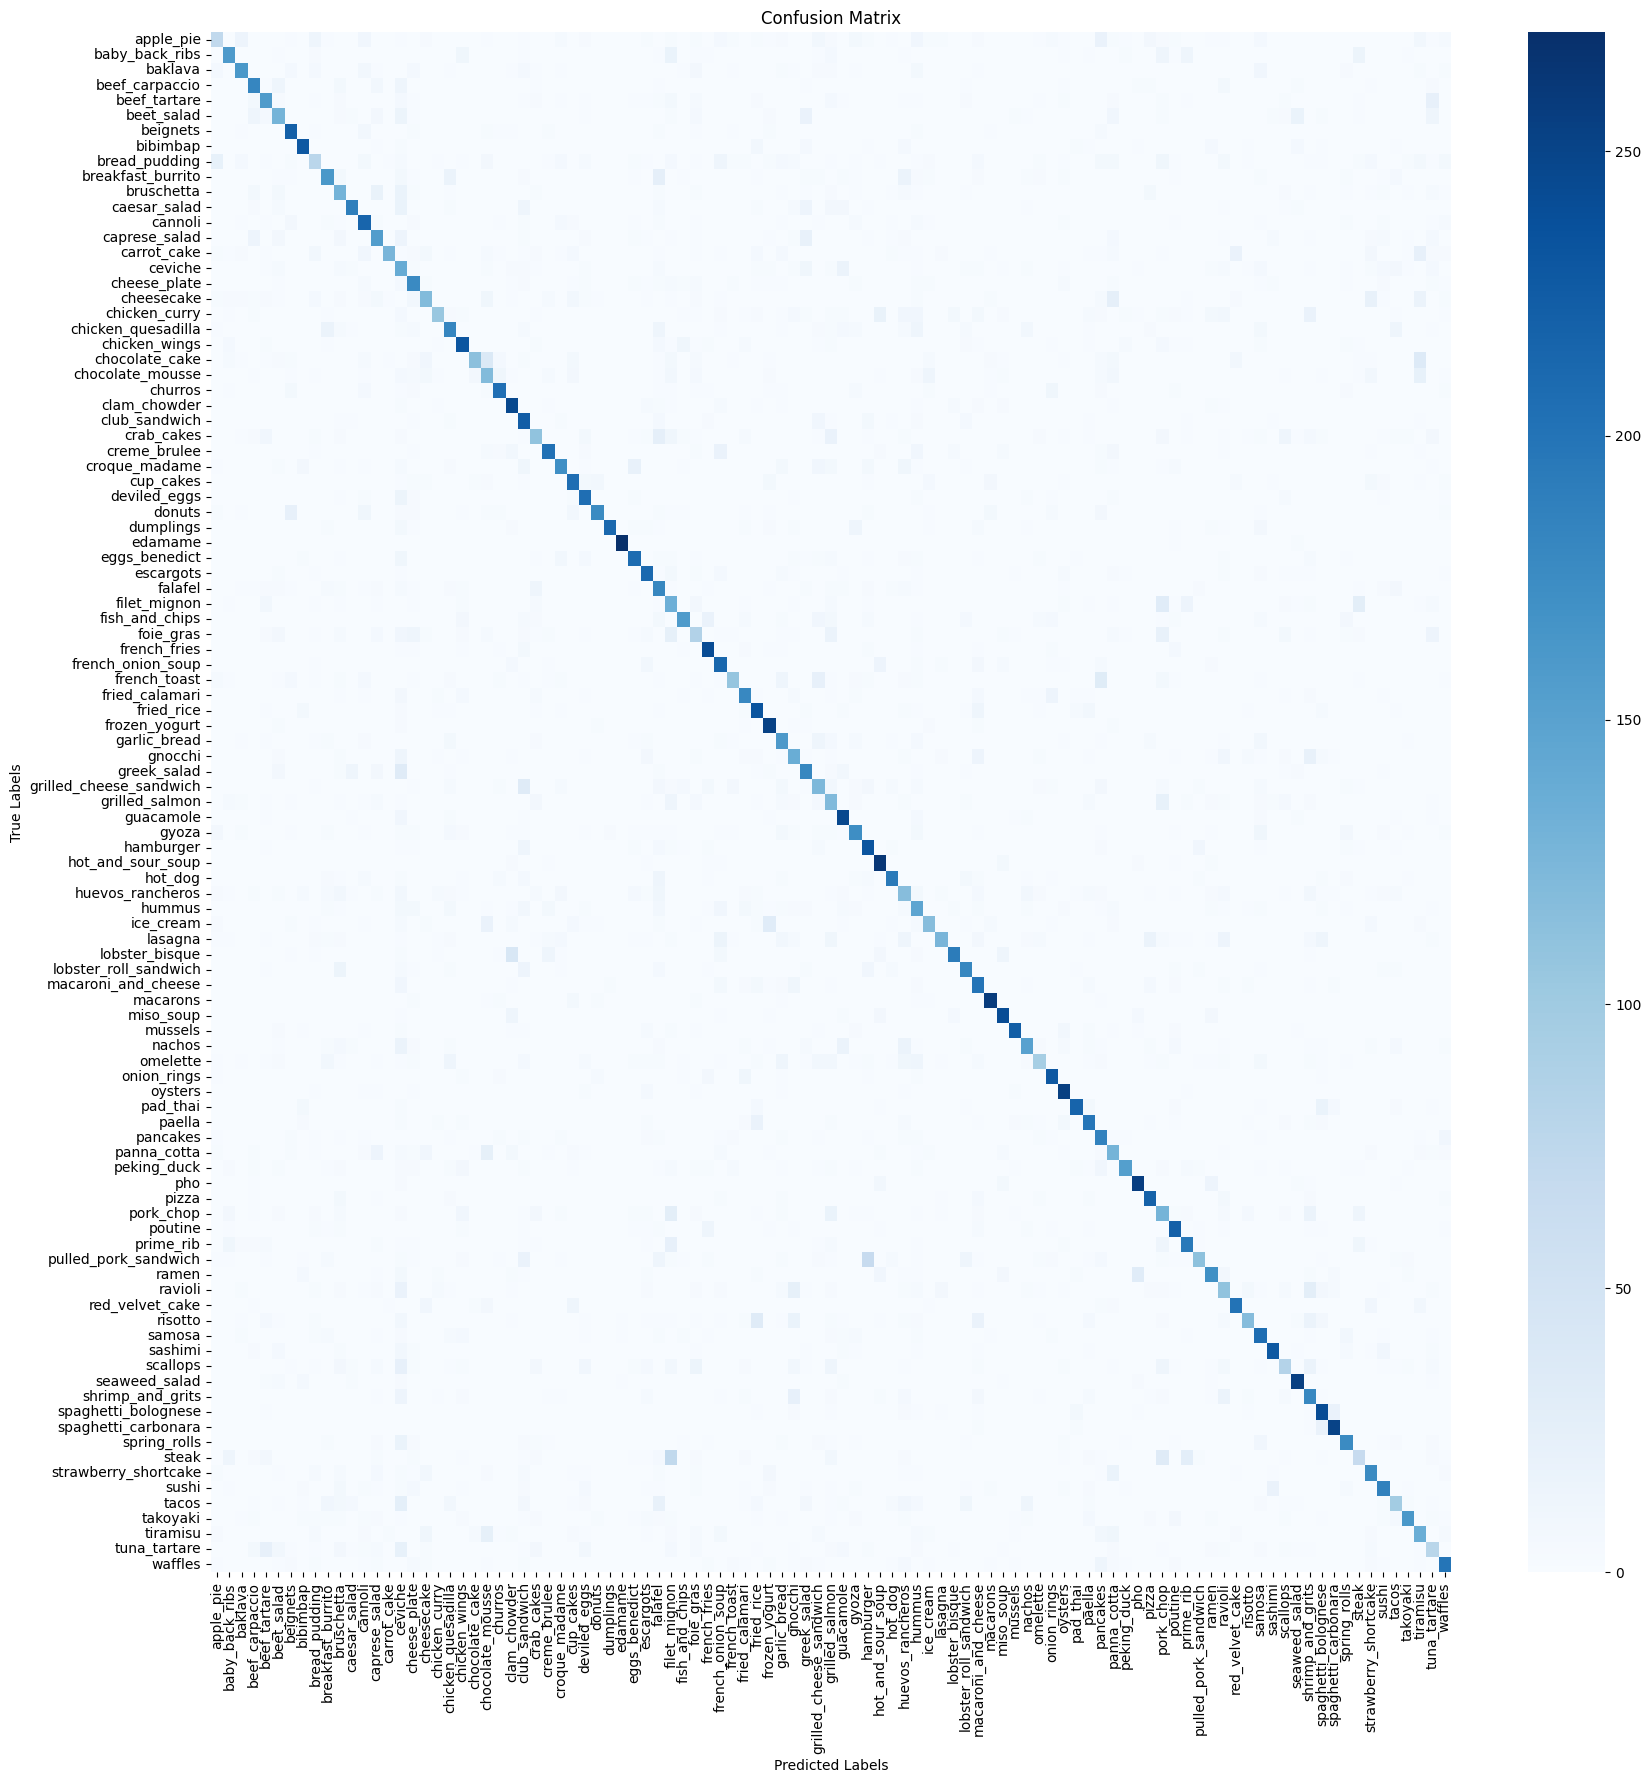

In [42]:
model_evaluation(mobile_net_model,test_images)